# Session 2: Missing Values, Data Quality, and EDA

Goals:
- Understand why data cleaning is never neutral
- Learn how missing values encode assumptions
- Learn how to explore data visually with intent

Rule:
There is no such thing as a “small” data cleaning decision.
Every choice changes the story the data tells.


## Missing Data Is Not Just Missing Data

NaN does NOT mean:
- “Ignore this”
- “Fill it later”
- “Pandas problem”

NaN means:
- Something happened in data collection
- Something is unknown
- Something was not applicable

Missing data is a **signal**, not just a problem.


## Types of Missing Values (Conceptual)

### 1. Missing Completely at Random (Rare)
- Example: sensor failed randomly
- Dropping rows usually safe

### 2. Missing Due to Data Collection
- Example: some neighborhoods didn’t report garage size
- Dropping may introduce bias

### 3. Not Applicable
- Example: no garage → GarageCars is missing
- Filling with 0 encodes a real-world assumption

Key point:
You cannot choose a strategy without understanding *why* values are missing.


## Why Imputation Is Dangerous

When you fill missing values, you are saying:

- Mean → “Missing values are average”
- Median → “Missing values are typical”
- Mode → “Missing values behave like the most common case”
- Zero → “Absence means none”
- "Unknown" → “Missing is its own category”

None of these are neutral.
All of them inject assumptions into the data.


## Decision Framework (Use This Every Time)

For each column with missing values:

1. Is this column important for the problem?
2. Why is it missing?
3. What happens if I drop it entirely?
4. What assumption am I encoding if I fill it?

If you cannot answer these,
you are not allowed to fill the column.



-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [2]:
# load data
import pandas as pd
import numpy as np

df = pd.read_csv("house_prices.csv")
df.shape


(1500, 14)

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [3]:
# Find missing values
df.isna().sum().sort_values(ascending=False)

GarageCars                45
KitchenQual               30
DistanceToCityCenterKm    22
LotArea                   15
Neighborhood               0
Id                         0
GrLivArea                  0
OverallQual                0
YearBuilt                  0
FullBath                   0
CentralAir                 0
Fireplaces                 0
SaleCondition              0
SalePrice                  0
dtype: int64

Teaching points:

Which columns have missing values?

Are they few or many?

Numeric vs categorical?

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [4]:
# Missing value percentages
(df.isna().mean() * 100).sort_values(ascending=False)


GarageCars                3.000000
KitchenQual               2.000000
DistanceToCityCenterKm    1.466667
LotArea                   1.000000
Neighborhood              0.000000
Id                        0.000000
GrLivArea                 0.000000
OverallQual               0.000000
YearBuilt                 0.000000
FullBath                  0.000000
CentralAir                0.000000
Fireplaces                0.000000
SaleCondition             0.000000
SalePrice                 0.000000
dtype: float64

Ask verbally:

At what point is a column “too missing”?

Does percentage alone decide?

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [5]:
# Separate Numerical & CAtegorical columns
numeric_cols = df.select_dtypes(include=np.number).columns
categorical_cols = df.select_dtypes(exclude=np.number).columns

numeric_cols, categorical_cols

(Index(['Id', 'YearBuilt', 'LotArea', 'OverallQual', 'GrLivArea', 'FullBath',
        'GarageCars', 'Fireplaces', 'DistanceToCityCenterKm', 'SalePrice'],
       dtype='object'),
 Index(['Neighborhood', 'CentralAir', 'KitchenQual', 'SaleCondition'], dtype='object'))

Rule:

Numeric and categorical columns are treated differently

Same strategy across all columns is always wrong

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [6]:
# Strategy 1: Drop rows with missing values
df_drop_rows = df.dropna()
df.shape, df_drop_rows.shape

((1500, 14), (1391, 14))

Discussion:

How many rows did we lose?

Is this random or systematic?

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [7]:
# Strategy 2: Dropping Columns (Code)
df_drop_cols = df.dropna(axis=1)
df.shape, df_drop_cols.shape

((1500, 14), (1500, 10))

Ask:

Did we drop important information?

Would we drop the target if it had NaNs?

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [8]:
df['CentralAir'].value_counts()

CentralAir
Y    1324
N     176
Name: count, dtype: int64

In [9]:
# Strategy 3: Imputation, Filling Numeric Columns
df_filled_numeric = df.copy()

# for each numeric col inside df_filled_numeric, fill missing values with median
for col in numeric_cols:
    df_filled_numeric[col] = df_filled_numeric[col].fillna(
        df_filled_numeric[col].median()
    )

print(df_filled_numeric.isna().sum())


Id                         0
Neighborhood               0
YearBuilt                  0
LotArea                    0
OverallQual                0
GrLivArea                  0
FullBath                   0
GarageCars                 0
Fireplaces                 0
CentralAir                 0
KitchenQual               30
DistanceToCityCenterKm     0
SaleCondition              0
SalePrice                  0
dtype: int64


Explicitly say:

Median assumes “typical value”

This compresses variability

Models like this artificially

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [10]:
df_filled_numeric.columns

Index(['Id', 'Neighborhood', 'YearBuilt', 'LotArea', 'OverallQual',
       'GrLivArea', 'FullBath', 'GarageCars', 'Fireplaces', 'CentralAir',
       'KitchenQual', 'DistanceToCityCenterKm', 'SaleCondition', 'SalePrice'],
      dtype='object')

In [11]:
# Strategy 4: Imputation, Filling Categorical Columns

df_filled_cat = df.copy()
df_numt_new = df[['Id', 'Neighborhood', 'YearBuilt', 'LotArea', 'OverallQual',
       'GrLivArea', 'FullBath', 'GarageCars', 'Fireplaces', 'CentralAir',
       'DistanceToCityCenterKm', 'SaleCondition', 'SalePrice']].copy()
# for each categorical col inside df_filled_cat, fill missing values with "Unknown"
for col in categorical_cols:
    df_filled_cat[col] = df_filled_cat[col].fillna("Unknown")

print(df_filled_cat.isna().sum())

Id                         0
Neighborhood               0
YearBuilt                  0
LotArea                   15
OverallQual                0
GrLivArea                  0
FullBath                   0
GarageCars                45
Fireplaces                 0
CentralAir                 0
KitchenQual                0
DistanceToCityCenterKm    22
SaleCondition              0
SalePrice                  0
dtype: int64


“Unknown” is a deliberate category

It preserves information about missingness

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# EDA SECTION

## Exploratory Data Analysis (EDA)

EDA is not:
- Pretty charts
- Dashboard screenshots
- Random plots

EDA is:
- Asking questions visually
- Looking for structure, errors, and surprises
- Deciding what deserves modeling attention

Every plot must answer a question.

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

<Figure size 640x480 with 0 Axes>

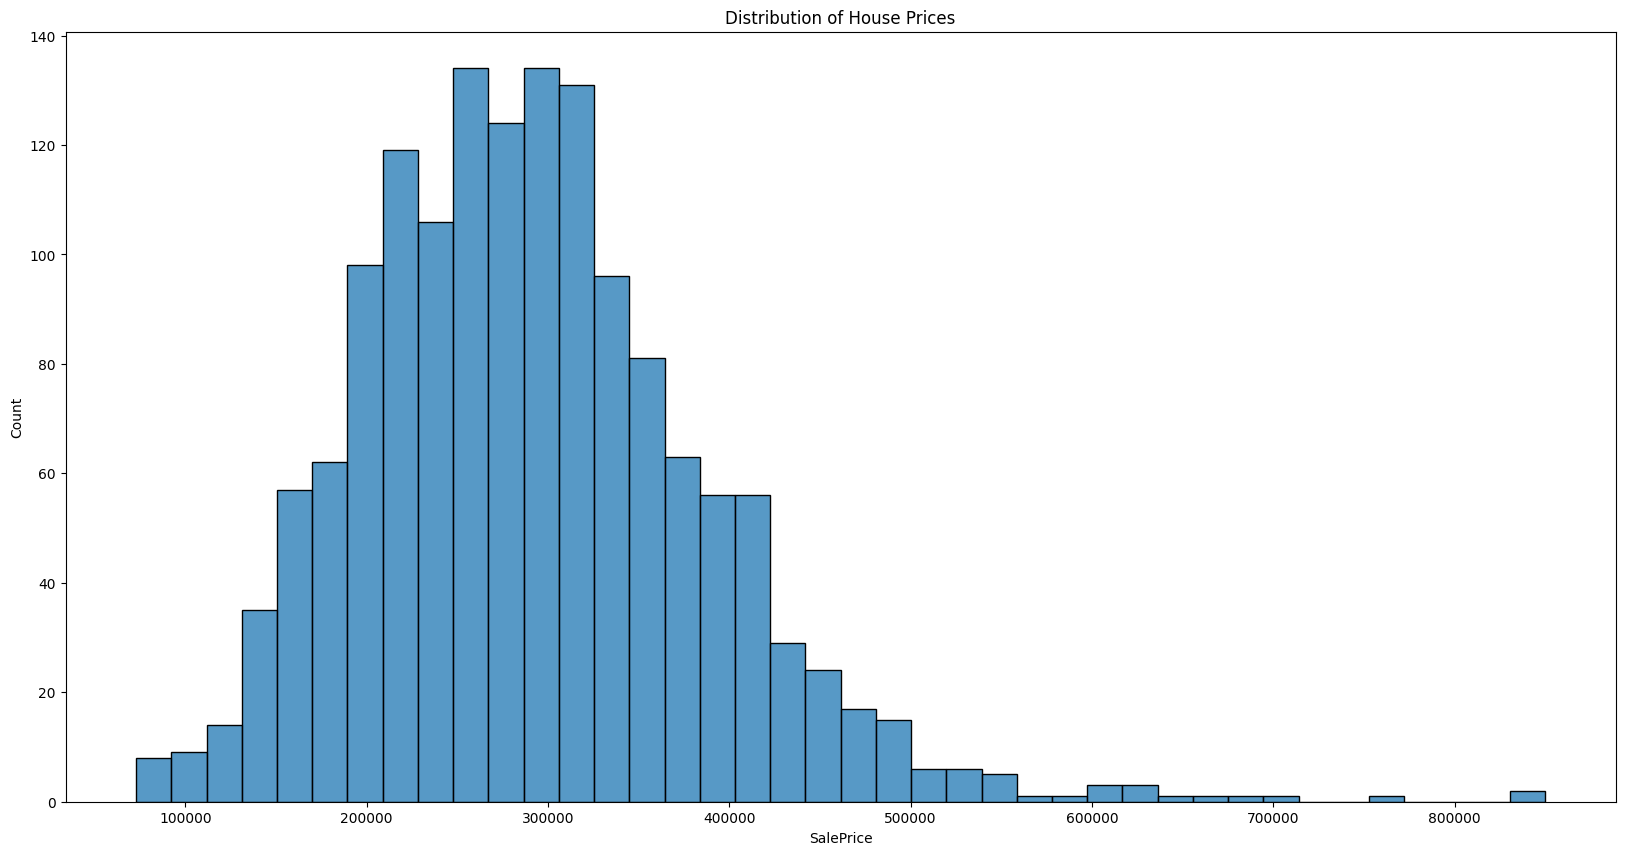

In [20]:
# Distribution chart
plt.figure()
plt.figure(figsize=(20, 10))
sns.histplot(df["SalePrice"], bins=40)
plt.title("Distribution of House Prices")
plt.show()

Ask:

Is it skewed?

Are there extreme values?

Would mean be misleading?

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

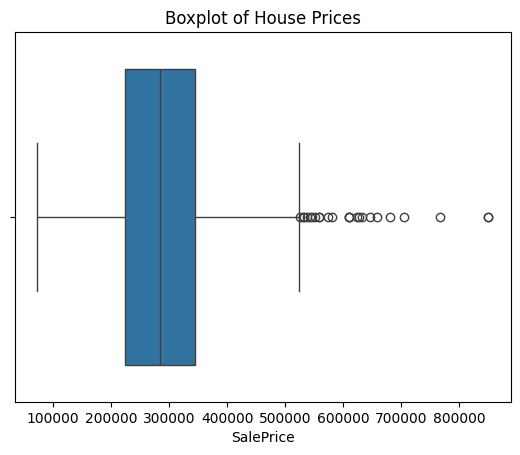

In [14]:
# Boxplot chart for outliers
plt.figure()
sns.boxplot(x=df["SalePrice"])
plt.title("Boxplot of House Prices")
plt.show()

Outliers may be errors or rare truths

Never remove without reasoning

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

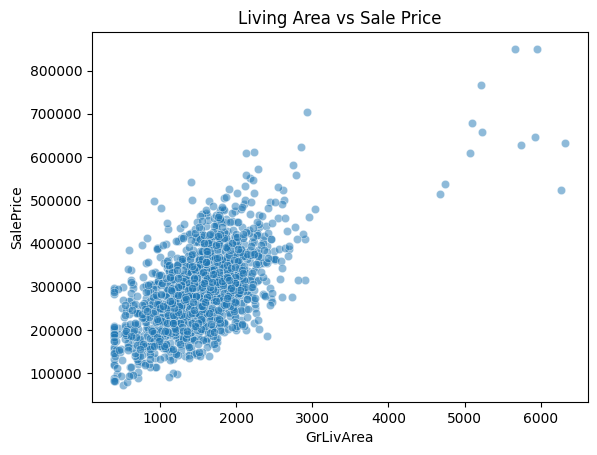

In [15]:
# Scatter plot of Living Area vs Sale Price, alpha means transparency
plt.figure()
sns.scatterplot(
    x=df["GrLivArea"],
    y=df["SalePrice"],
    alpha=0.5)
plt.title("Living Area vs Sale Price")
plt.show()





Does the relationship make sense?

Is it linear?

Any obvious anomalies?

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

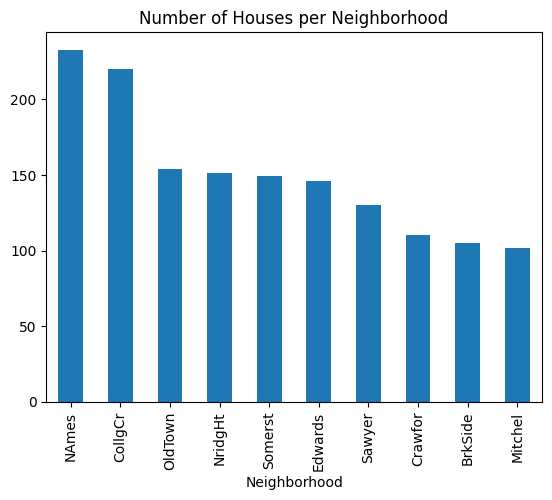

In [16]:
# Bar Chart, Categorical columns distribution
plt.figure()
df["Neighborhood"].value_counts().plot(kind="bar")
plt.title("Number of Houses per Neighborhood")
plt.show()


-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

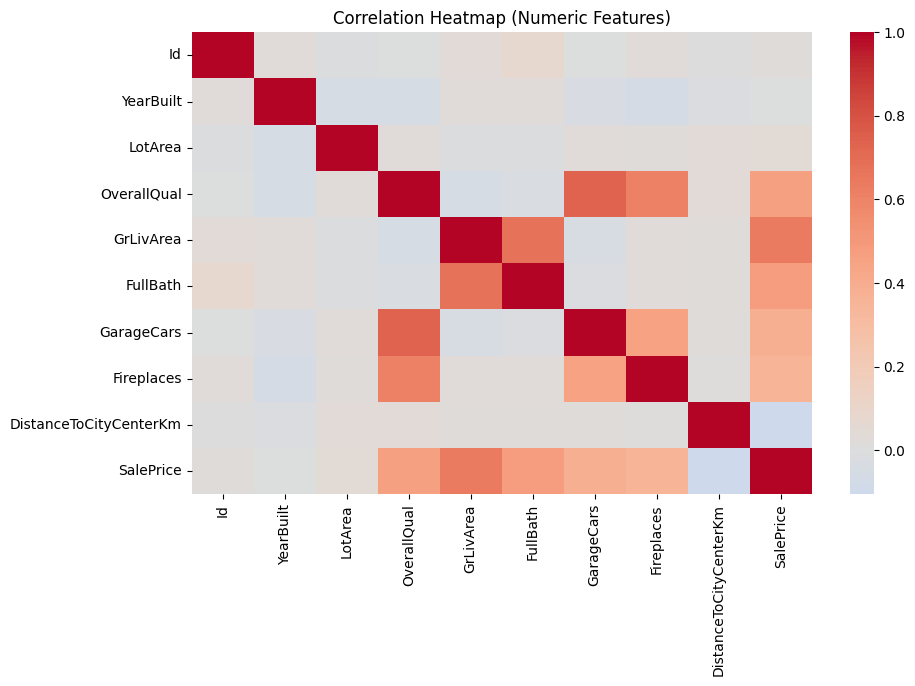

In [17]:
# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df[numeric_cols].corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

High correlation ≠ causation

Redundant features add noise

## What You Should Be Thinking During EDA

For each feature, ask:
- Does this logically affect house price?
- Is the relationship strong or weak?
- Is it linear or complex?
- Does this feature exist at prediction time?

EDA is where bad features are killed.


## Homework (Mandatory)

1. Pick TWO columns with missing values.
   - Explain why they might be missing.
   - Choose a filling strategy.
   - Justify it in words.

2. Create ONE new feature you believe affects price.
   - Explain the assumption behind it.

3. Create THREE plots:
   - One distribution plot
   - One relationship with SalePrice
   - One categorical frequency plot

4. Write short answers:
   - Which feature seems most important?
   - Which feature seems useless?
   - Which assumption worries you most?

No modeling.
If you model, you failed the assignment.
